# #1 Importing Libraries

In [78]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as ltb 
import xgboost
import warnings
import shap

from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN 
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix, classification_report, make_scorer, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from catboost import CatBoostClassifier
from xgboost.sklearn import XGBClassifier

import modules.functions as fnc
warnings.filterwarnings('ignore')

# #2 Loading Dataset

In [3]:
df = pd.read_csv('../data/alzheimers_disease_data.csv')
df.head(5)

,PatientID,Age,Gender,Ethnicity,EducationLevel,BMI,Smoking,AlcoholConsumption,PhysicalActivity,DietQuality,...,MemoryComplaints,BehavioralProblems,ADL,Confusion,Disorientation,PersonalityChanges,DifficultyCompletingTasks,Forgetfulness,Diagnosis,DoctorInCharge
0,4751,73,0,0,2,22.927749,0,13.297218,6.327112,1.347214,...,0,0,1.725883,0,0,0,1,0,0,XXXConfid
1,4752,89,0,0,0,26.827681,0,4.542524,7.619885,0.518767,...,0,0,2.592424,0,0,0,0,1,0,XXXConfid
2,4753,73,0,3,1,17.795882,0,19.555085,7.844988,1.826335,...,0,0,7.119548,0,1,0,1,0,0,XXXConfid
3,4754,74,1,0,1,33.800817,1,12.209266,8.428001,7.435604,...,0,1,6.481226,0,0,0,0,0,0,XXXConfid
4,4755,89,0,0,0,20.716974,0,18.454356,6.310461,0.795498,...,0,0,0.014691,0,0,1,1,0,0,XXXConfid


In [4]:
df = df.drop(columns=['PatientID', 'DoctorInCharge'], axis=1)

In [5]:
gender = {
    0 : 'Male',
    1 : 'Female'
}

eth = {
    0 : 'Caucasian',
    1 : 'African American',
    2 : 'Asian',
    3 : 'Other'
}

ed_lvl = {
    0 : 'None',
    1 : 'High School',
    2 : "Bachelor's",
    3 : 'Higher'
}

binom = {
    0 : 'No',
    1 : 'Yes'
}

diagnosis = {
    0 : 'Healthy',
    1 : 'Unhealthy'
}

In [6]:
df_cat = df.assign(
    Gender=df['Gender'].map(gender),
    Ethnicity=df['Ethnicity'].map(eth),
    EducationLevel=df['EducationLevel'].map(ed_lvl),
    Smoking=df['Smoking'].map(binom),
    FamilyHistoryAlzheimers=df['FamilyHistoryAlzheimers'].map(binom),
    CardiovascularDisease=df['CardiovascularDisease'].map(binom),
    Diabetes=df['Diabetes'].map(binom),
    Depression=df['Depression'].map(binom),
    HeadInjury=df['HeadInjury'].map(binom),
    Hypertension=df['Hypertension'].map(binom),
    MemoryComplaints=df['MemoryComplaints'].map(binom),
    BehavioralProblems=df['BehavioralProblems'].map(binom),
    Confusion=df['Confusion'].map(binom),
    Disorientation=df['Disorientation'].map(binom),
    PersonalityChanges=df['PersonalityChanges'].map(binom),
    DifficultyCompletingTasks=df['DifficultyCompletingTasks'].map(binom),
    Forgetfulness=df['Forgetfulness'].map(binom),
    Diagnosis=df['Diagnosis'].map(diagnosis)
)

# #3 EDA

In [7]:
df_cat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2149 entries, 0 to 2148
Data columns (total 33 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Age                        2149 non-null   int64  
 1   Gender                     2149 non-null   object 
 2   Ethnicity                  2149 non-null   object 
 3   EducationLevel             2149 non-null   object 
 4   BMI                        2149 non-null   float64
 5   Smoking                    2149 non-null   object 
 6   AlcoholConsumption         2149 non-null   float64
 7   PhysicalActivity           2149 non-null   float64
 8   DietQuality                2149 non-null   float64
 9   SleepQuality               2149 non-null   float64
 10  FamilyHistoryAlzheimers    2149 non-null   object 
 11  CardiovascularDisease      2149 non-null   object 
 12  Diabetes                   2149 non-null   object 
 13  Depression                 2149 non-null   objec

In [8]:
df.isna().any().any()

np.False_

In [9]:
df.duplicated().any()

np.False_

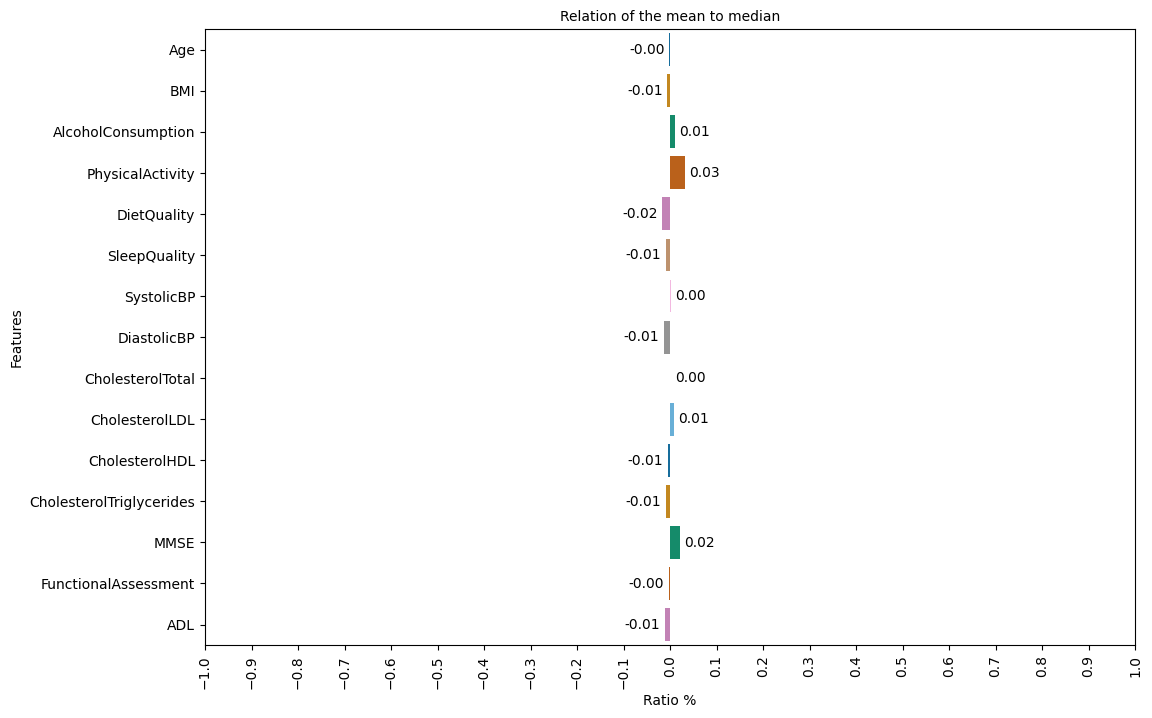

In [10]:
fnc.mean_to_median(data=df_cat, figsize=(12, 8))

In [11]:
df_cat.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Age,2149.0,74.908795,8.990221,60.000000,67.000000,75.000000,83.000000,90.000000
BMI,2149.0,27.655697,7.217438,15.008851,21.611408,27.823924,33.869778,39.992767
AlcoholConsumption,2149.0,10.039442,5.757910,0.002003,5.139810,9.934412,15.157931,19.989293
PhysicalActivity,2149.0,4.920202,2.857191,0.003616,2.570626,4.766424,7.427899,9.987429
DietQuality,2149.0,4.993138,2.909055,0.009385,2.458455,5.076087,7.558625,9.998346
SleepQuality,2149.0,7.051081,1.763573,4.002629,5.482997,7.115646,8.562521,9.999840
SystolicBP,2149.0,134.264774,25.949352,90.000000,112.000000,134.000000,157.000000,179.000000
DiastolicBP,2149.0,89.847836,17.592496,60.000000,74.000000,91.000000,105.000000,119.000000
CholesterolTotal,2149.0,225.197519,42.542233,150.093316,190.252963,225.086430,262.031657,299.993352
CholesterolLDL,2149.0,124.335944,43.366584,50.230707,87.195798,123.342593,161.733733,199.965665


In [12]:
df_cat.describe(include=['O']).transpose()

,count,unique,top,freq
Gender,2149,2,Female,1088
Ethnicity,2149,4,Caucasian,1278
EducationLevel,2149,4,High School,854
Smoking,2149,2,No,1529
FamilyHistoryAlzheimers,2149,2,No,1607
CardiovascularDisease,2149,2,No,1839
Diabetes,2149,2,No,1825
Depression,2149,2,No,1718
HeadInjury,2149,2,No,1950
Hypertension,2149,2,No,1829


In [13]:
correlations = df.corrwith(df['Diagnosis']).sort_values(ascending=False).to_frame('R')
correlations[(correlations['R'] >= 0.1) | (correlations['R'] <= -0.1)]

,R
Diagnosis,1.000000
MemoryComplaints,0.306742
BehavioralProblems,0.224350
MMSE,-0.237126
ADL,-0.332346
FunctionalAssessment,-0.364898


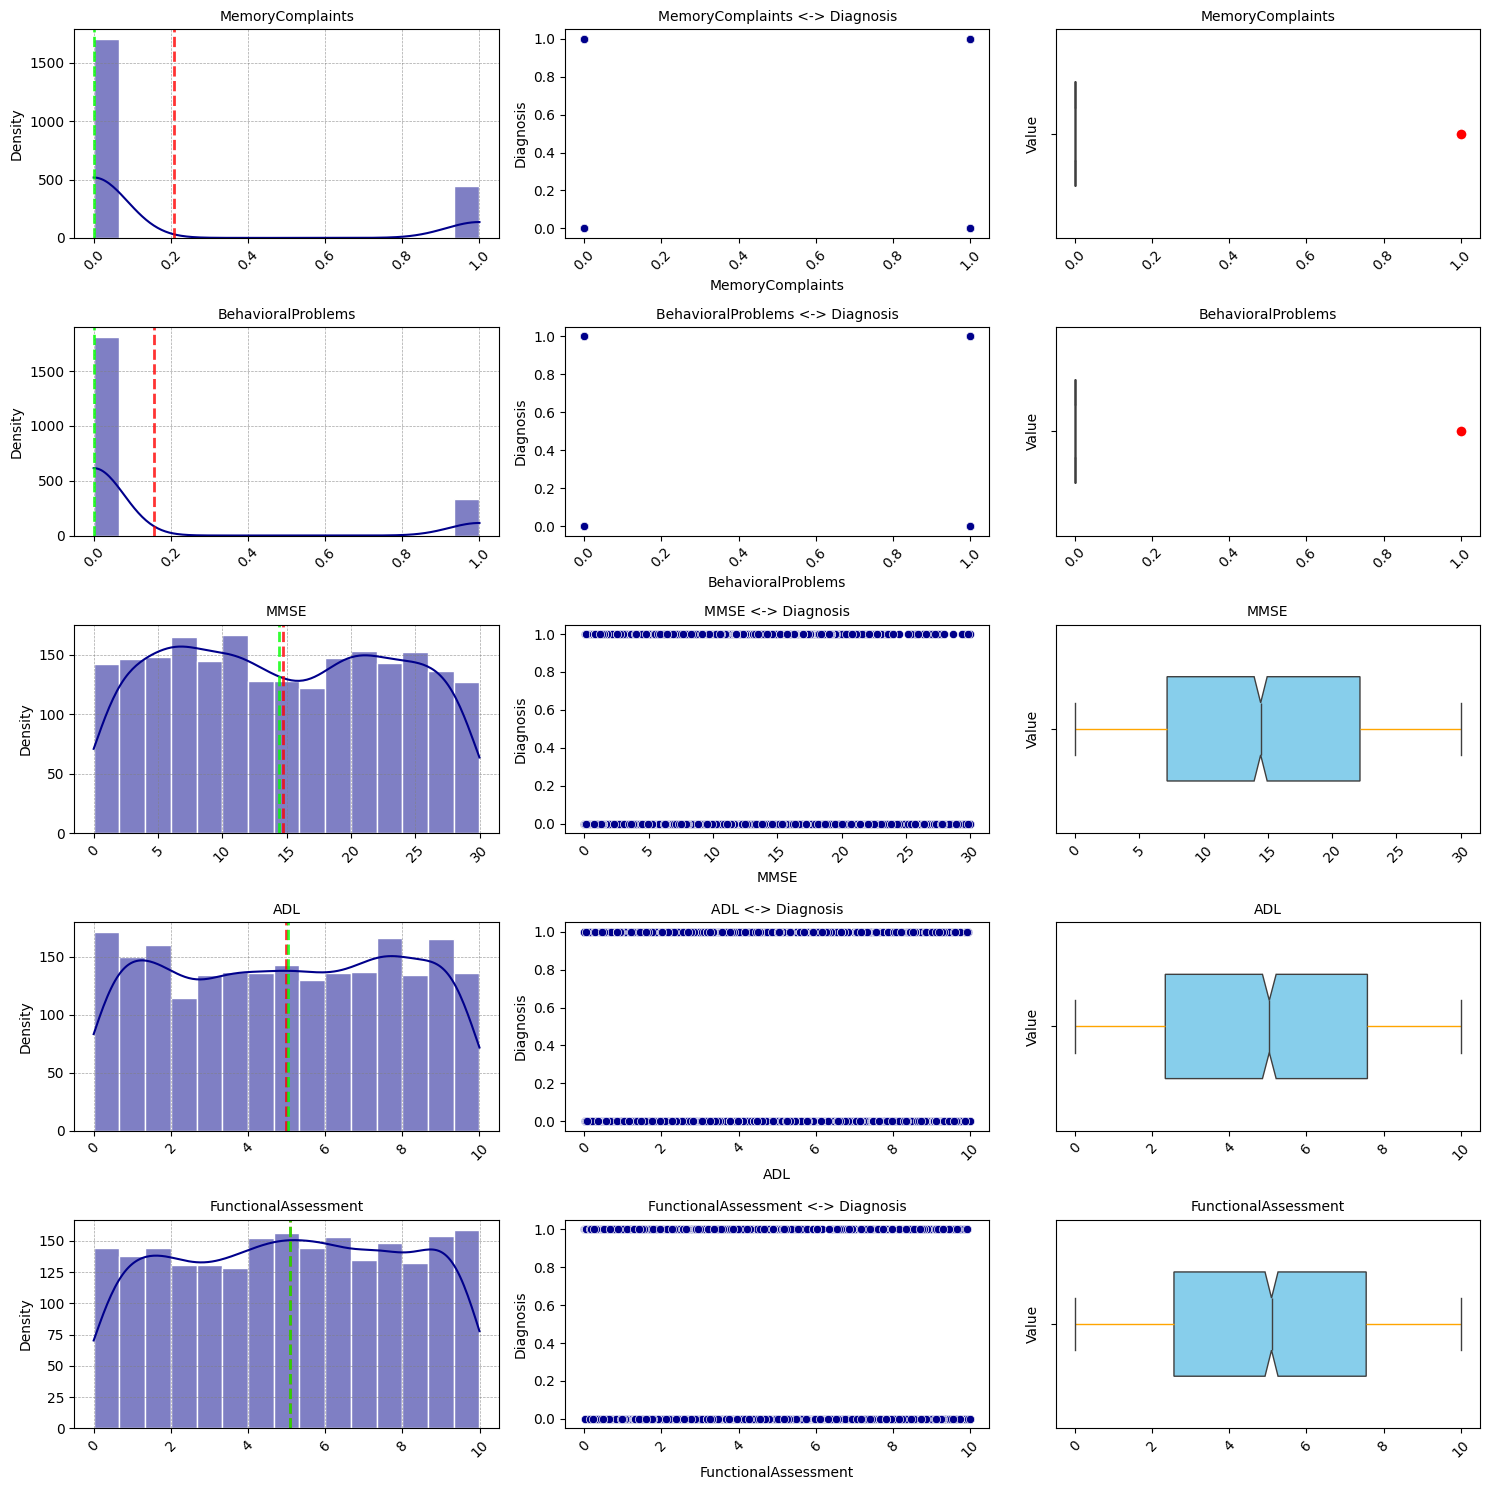

In [14]:
fnc.feature_plot(df, ['MemoryComplaints', 'BehavioralProblems', 'MMSE', 'ADL', 'FunctionalAssessment'], 'Diagnosis', (15,15))

## Demographics

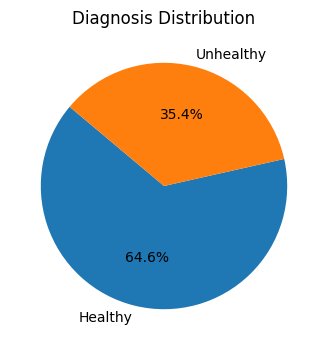

In [15]:
diag = df_cat['Diagnosis'].value_counts()
diag_normalized = df_cat['Diagnosis'].value_counts(normalize=True)

plt.figure(figsize=(4, 4))
plt.pie(diag, labels=diag.index, autopct='%1.1f%%', startangle=140)
plt.title('Diagnosis Distribution')
plt.show()

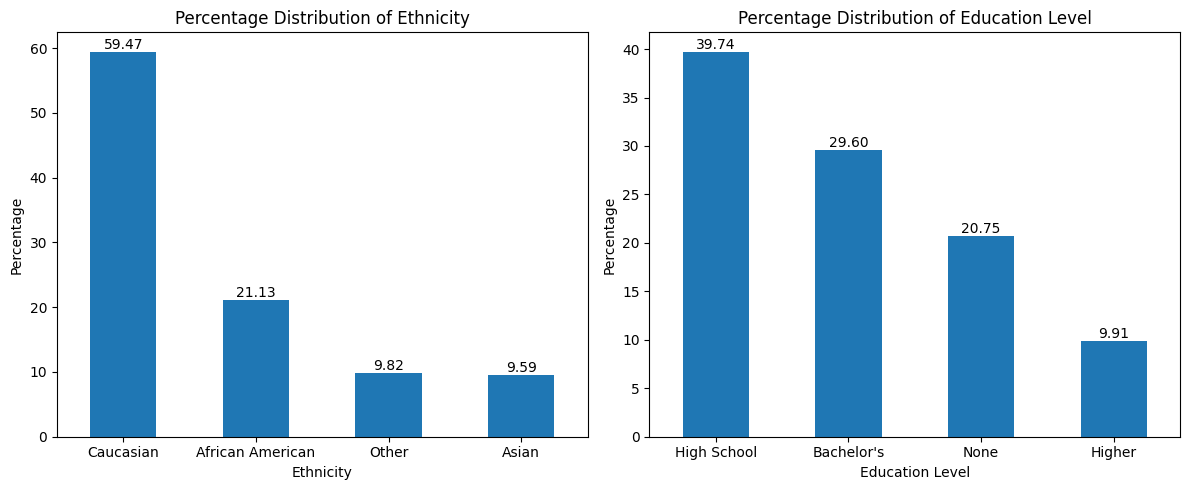

In [16]:
demo_distribut = df_cat['Ethnicity'].value_counts(normalize=True)*100
demo_distribut = demo_distribut.to_frame('Percentage')

Edu_distribut = df_cat['EducationLevel'].value_counts(normalize=True)*100
Edu_distribut = Edu_distribut.to_frame('Percentage')

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

ax1 = demo_distribut.plot(kind='bar', ax=axes[0], width=0.5, legend=False)
for container in ax1.containers:
    ax1.bar_label(container, fmt='%.2f', label_type='edge', fontsize=10)
ax1.set_xlabel('Ethnicity')
ax1.set_ylabel('Percentage')
ax1.set_title('Percentage Distribution of Ethnicity')
ax1.set_xticks(ax1.get_xticks())
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=0)

ax2 = Edu_distribut.plot(kind='bar', ax=axes[1], width=0.5, legend=False)
for container in ax2.containers:
    ax2.bar_label(container, fmt='%.2f', label_type='edge', fontsize=10)
ax2.set_xlabel('Education Level')
ax2.set_ylabel('Percentage')
ax2.set_title('Percentage Distribution of Education Level')
ax2.set_xticks(ax2.get_xticks())
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=0)

plt.tight_layout()
plt.show()


In [17]:
total_dem = df_cat[['Diagnosis','Gender']].value_counts(normalize=True).sort_index().to_frame('Percentage')
total_dem.style.background_gradient(cmap='Blues')

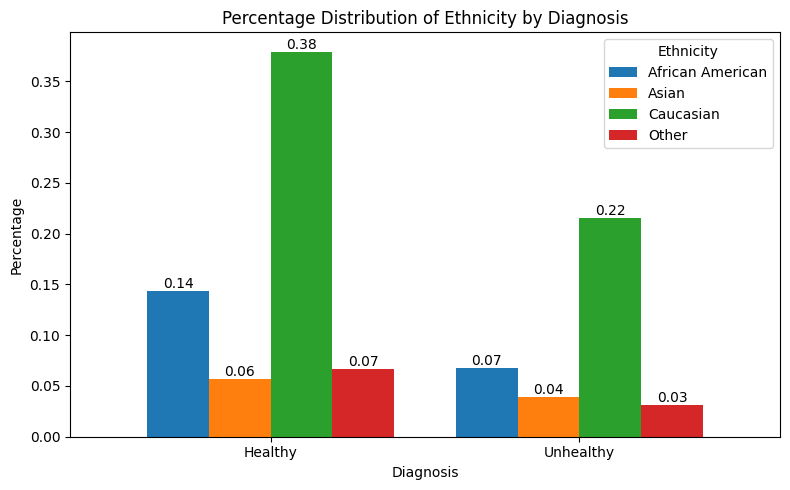

In [18]:
data = df_cat[['Diagnosis', 'Ethnicity']].value_counts(normalize=True).sort_index().to_frame('Percentage')
data.reset_index(inplace=True)
pivot_data = data.pivot(index='Diagnosis', columns='Ethnicity', values='Percentage')
ax = pivot_data.plot(kind='bar', figsize=(8, 5), width=0.8)
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', label_type='edge', fontsize=10)
plt.xlabel('Diagnosis')
plt.ylabel('Percentage')
plt.title('Percentage Distribution of Ethnicity by Diagnosis')
plt.legend(title='Ethnicity')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

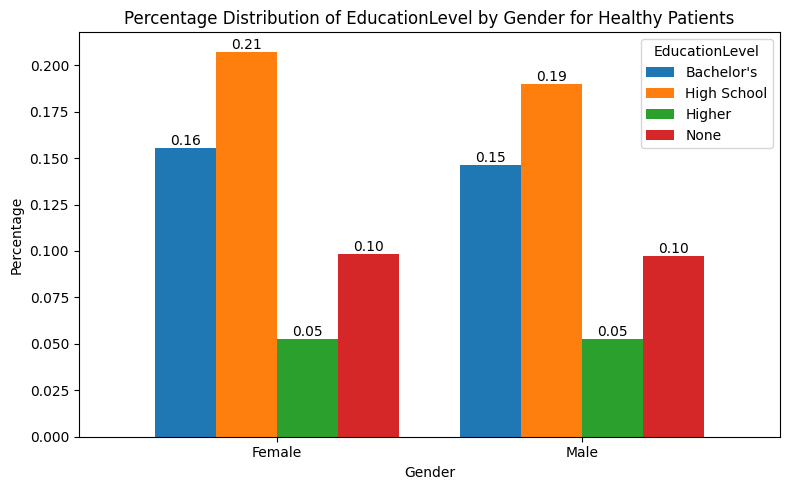

In [19]:
data = df_cat[df_cat['Diagnosis'] == 'Healthy'][['Gender', 'EducationLevel']].value_counts(normalize=True).sort_index().to_frame('Percentage')
data.reset_index(inplace=True)
pivot_data = data.pivot(index='Gender', columns='EducationLevel', values='Percentage')
ax = pivot_data.plot(kind='bar', figsize=(8, 5), width=0.8)
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', label_type='edge', fontsize=10)
plt.xlabel('Gender')
plt.ylabel('Percentage')
plt.title('Percentage Distribution of EducationLevel by Gender for Healthy Patients')
plt.legend(title='EducationLevel')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

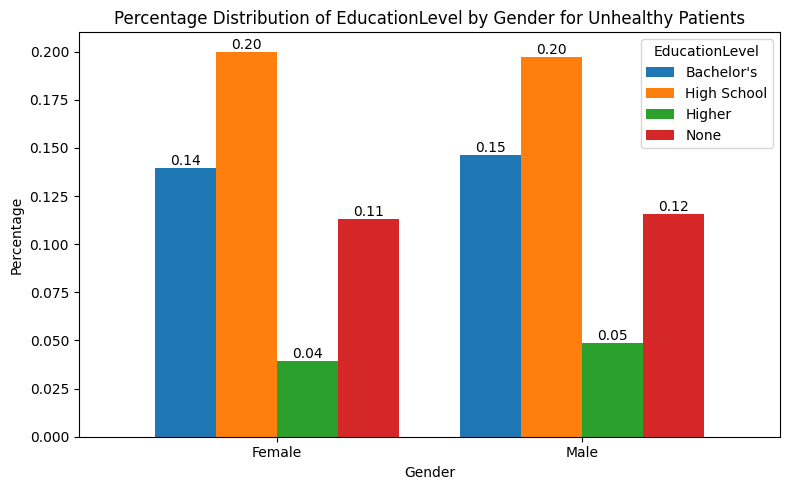

In [20]:
data = df_cat[df_cat['Diagnosis'] == 'Unhealthy'][['Gender', 'EducationLevel']].value_counts(normalize=True).sort_index().to_frame('Percentage')
data.reset_index(inplace=True)
pivot_data = data.pivot(index='Gender', columns='EducationLevel', values='Percentage')
ax = pivot_data.plot(kind='bar', figsize=(8, 5), width=0.8)
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', label_type='edge', fontsize=10)
plt.xlabel('Gender')
plt.ylabel('Percentage')
plt.title('Percentage Distribution of EducationLevel by Gender for Unhealthy Patients')
plt.legend(title='EducationLevel')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

## Lifestyle Factors

In [21]:
life_factors = df_cat[['Smoking', 'BMI', 'AlcoholConsumption', 'PhysicalActivity', 'DietQuality', 'SleepQuality', 'Diagnosis']]

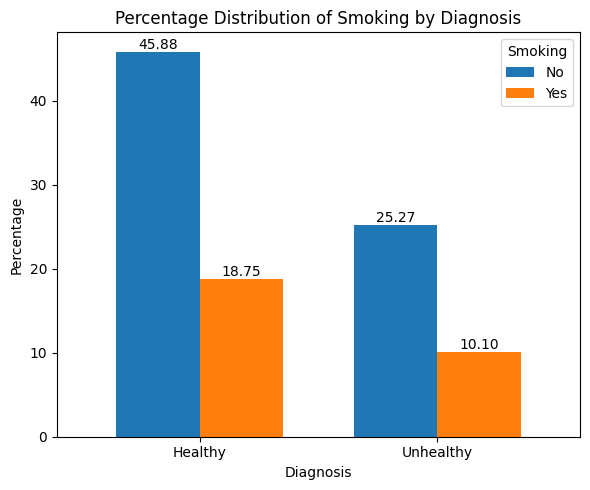

In [22]:
smokers = life_factors[['Diagnosis', 'Smoking']].value_counts(normalize=True).sort_index().to_frame('Percentage')
smokers['Percentage'] *= 100
smokers_pivot = smokers.reset_index().pivot(index='Diagnosis', columns='Smoking', values='Percentage')

fig, ax = plt.subplots(figsize=(6, 5))
smokers_pivot.plot(kind='bar', ax=ax, width=0.7, legend=True)

for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', label_type='edge', fontsize=10)
ax.set_xlabel('Diagnosis')
ax.set_ylabel('Percentage')
ax.set_title('Percentage Distribution of Smoking by Diagnosis')
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

plt.tight_layout()
plt.show()

In [23]:
life_factors.groupby('Diagnosis')[['BMI', 'AlcoholConsumption', 'PhysicalActivity', 'DietQuality', 'SleepQuality']].mean()

,BMI,AlcoholConsumption,PhysicalActivity,DietQuality,SleepQuality
Diagnosis,,,,,
Healthy,27.515092,10.071880,4.90764,4.974839,7.124832
Unhealthy,27.912670,9.980156,4.94316,5.026581,6.916292


## Medical History

In [24]:
med_hist = df_cat[['FamilyHistoryAlzheimers', 
                   'CardiovascularDisease', 
                   'Diabetes', 
                   'Depression', 
                   'HeadInjury', 
                   'Hypertension', 
                   'Diagnosis'
                   ]]

In [25]:
med_hist[['Diagnosis', 'FamilyHistoryAlzheimers']].value_counts(normalize=True).sort_index()

Diagnosis  FamilyHistoryAlzheimers
Healthy    No                         0.476501
           Yes                        0.169846
Unhealthy  No                         0.271289
           Yes                        0.082364
Name: proportion, dtype: float64

In [26]:
med_hist[['Diagnosis', 'CardiovascularDisease']].value_counts(normalize=True).sort_index()

Diagnosis  CardiovascularDisease
Healthy    No                       0.558399
           Yes                      0.087948
Unhealthy  No                       0.297348
           Yes                      0.056305
Name: proportion, dtype: float64

In [27]:
med_hist[['Diagnosis', 'Diabetes']].value_counts(normalize=True).sort_index()

Diagnosis  Diabetes
Healthy    No          0.543509
           Yes         0.102839
Unhealthy  No          0.305724
           Yes         0.047929
Name: proportion, dtype: float64

In [28]:
med_hist[['Diagnosis', 'Depression']].value_counts(normalize=True).sort_index()

Diagnosis  Depression
Healthy    No            0.515589
           Yes           0.130758
Unhealthy  No            0.283853
           Yes           0.069800
Name: proportion, dtype: float64

In [29]:
med_hist[['Diagnosis', 'HeadInjury']].value_counts(normalize=True).sort_index()

Diagnosis  HeadInjury
Healthy    No            0.583527
           Yes           0.062820
Unhealthy  No            0.323872
           Yes           0.029781
Name: proportion, dtype: float64

In [30]:
med_hist[['Diagnosis', 'Hypertension']].value_counts(normalize=True).sort_index()

Diagnosis  Hypertension
Healthy    No              0.556073
           Yes             0.090275
Unhealthy  No              0.295021
           Yes             0.058632
Name: proportion, dtype: float64

## Clinical Measurements

In [31]:
clinical_data = df_cat[['SystolicBP', 
                        'DiastolicBP', 
                        'CholesterolTotal', 
                        'CholesterolLDL', 
                        'CholesterolHDL', 
                        'CholesterolTriglycerides', 
                        'Diagnosis'
                       ]]

In [32]:
clinical_data.groupby('Diagnosis').mean()

,SystolicBP,DiastolicBP,CholesterolTotal,CholesterolLDL,CholesterolHDL,CholesterolTriglycerides
Diagnosis,,,,,,
Healthy,134.564435,89.778978,224.996342,125.361434,58.734832,226.571537
Unhealthy,133.717105,89.973684,225.565197,122.461726,60.795330,231.406671


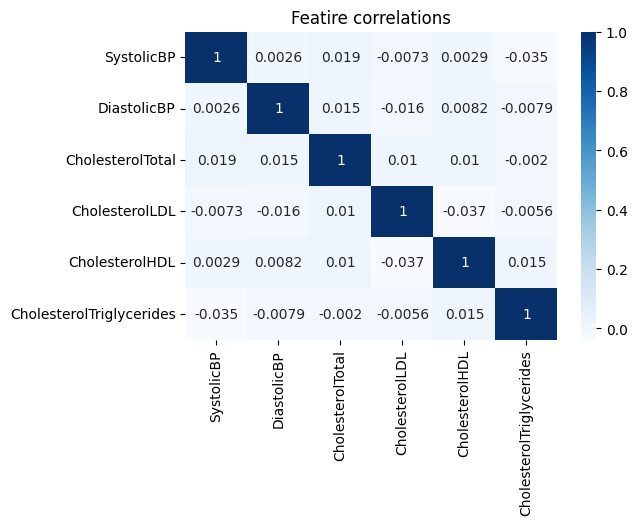

In [33]:
plt.figure(figsize=(6, 4))
sns.heatmap(clinical_data.iloc[:,:-1].corr(), annot=True, cmap='Blues')
plt.title('Featire correlations')
plt.show()

## Cognitive and Functional Assessments

In [34]:
cog_func = df_cat[['MemoryComplaints', 'BehavioralProblems', 'MMSE', 'FunctionalAssessment', 'ADL', 'Diagnosis']]

In [35]:
cog_func[['Diagnosis', 'MemoryComplaints']].value_counts(normalize=True).sort_index()

Diagnosis  MemoryComplaints
Healthy    No                  0.571429
           Yes                 0.074919
Unhealthy  No                  0.220568
           Yes                 0.133085
Name: proportion, dtype: float64

In [36]:
cog_func[['Diagnosis', 'BehavioralProblems']].value_counts(normalize=True).sort_index()

Diagnosis  BehavioralProblems
Healthy    No                    0.583993
           Yes                   0.062355
Unhealthy  No                    0.259190
           Yes                   0.094463
Name: proportion, dtype: float64

In [37]:
cog_func.iloc[:,-4:].groupby('Diagnosis').mean()

,MMSE,FunctionalAssessment,ADL
Diagnosis,,,
Healthy,16.265543,5.860669,5.707951
Unhealthy,11.994657,3.653380,3.657938


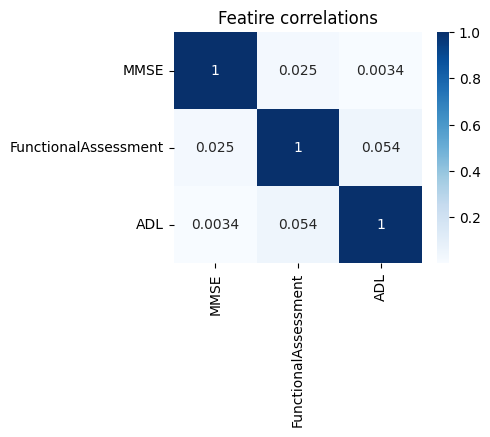

In [38]:
plt.figure(figsize=(4, 3))
sns.heatmap(cog_func.iloc[:,-4:-1].corr(), annot=True, cmap='Blues')
plt.title('Featire correlations')
plt.show()

## Symptoms

In [39]:
symptoms = df_cat[['Confusion', 
                   'Disorientation', 
                   'PersonalityChanges', 
                   'DifficultyCompletingTasks', 
                   'Forgetfulness', 
                   'Diagnosis'
                   ]]

In [40]:
symptoms[['Diagnosis', 'Confusion']].value_counts(normalize=True).sort_index()

Diagnosis  Confusion
Healthy    No           0.510005
           Yes          0.136342
Unhealthy  No           0.284784
           Yes          0.068869
Name: proportion, dtype: float64

In [41]:
symptoms[['Diagnosis', 'Disorientation']].value_counts(normalize=True).sort_index()

Diagnosis  Disorientation
Healthy    No                0.539786
           Yes               0.106561
Unhealthy  No                0.302001
           Yes               0.051652
Name: proportion, dtype: float64

In [42]:
symptoms[['Diagnosis', 'PersonalityChanges']].value_counts(normalize=True).sort_index()

Diagnosis  PersonalityChanges
Healthy    No                    0.545370
           Yes                   0.100977
Unhealthy  No                    0.303862
           Yes                   0.049791
Name: proportion, dtype: float64

In [43]:
symptoms[['Diagnosis', 'DifficultyCompletingTasks']].value_counts(normalize=True).sort_index()

Diagnosis  DifficultyCompletingTasks
Healthy    No                           0.545370
           Yes                          0.100977
Unhealthy  No                           0.295952
           Yes                          0.057701
Name: proportion, dtype: float64

In [44]:
symptoms[['Diagnosis', 'Forgetfulness']].value_counts(normalize=True).sort_index()

Diagnosis  Forgetfulness
Healthy    No               0.451373
           Yes              0.194974
Unhealthy  No               0.247092
           Yes              0.106561
Name: proportion, dtype: float64

# #4 Resampling - SMOTE & ADASYN

In [45]:
X = df.iloc[:,:-1]
Y = df['Diagnosis']
resample_smote = SMOTE(random_state=1)
X_smote, Y_smote = resample_smote.fit_resample(X, Y)
print('Resampled dataset shape %s' % Counter(Y_smote))

Resampled dataset shape Counter({0: 1389, 1: 1389})


In [46]:
resample_ada = ADASYN(random_state=1)
X_ada, Y_ada = resample_ada.fit_resample(X, Y)
print('Resampled dataset shape %s' % Counter(Y_ada))

Resampled dataset shape Counter({1: 1466, 0: 1389})


# #5 VIF - Multicolinearity verification

In [47]:
def calculate_vif(df):

    vif = pd.DataFrame()
    vif["variables"] = df.columns
    vif["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]

    return vif

In [48]:
vif_score = calculate_vif(X_smote)
len(vif_score[vif_score['VIF']<5]['variables'].values)

23

In [49]:
vif_score.query('VIF < 5').sort_values('VIF', ascending=False).style.background_gradient(cmap='Blues')

,variables,VIF
7,PhysicalActivity,4.208525
8,DietQuality,4.208494
6,AlcoholConsumption,4.142341
22,MMSE,4.065206
23,FunctionalAssessment,4.049840
26,ADL,3.775866
3,EducationLevel,2.885488
1,Gender,1.860543
2,Ethnicity,1.480212
31,Forgetfulness,1.380106


In [50]:
vif_score.query('VIF >= 5 and VIF <= 10').sort_values('VIF', ascending=False).style.background_gradient(cmap='Blues')

,variables,VIF
19,CholesterolLDL,9.058654
20,CholesterolHDL,7.913763
21,CholesterolTriglycerides,5.902082


In [51]:
vif_score.query('VIF > 10').sort_values('VIF', ascending=False).style.background_gradient(cmap='Blues')

,variables,VIF
0,Age,51.695599
18,CholesterolTotal,26.622819
17,DiastolicBP,25.482218
16,SystolicBP,25.415888
9,SleepQuality,17.640328
4,BMI,15.995186


# #6 ML Algorithms

In [52]:
X_train_smote, X_test_smote, Y_train_smote, Y_test_smote = train_test_split(X_smote,Y_smote, test_size=0.2, random_state=1)
X_train_ada, X_test_ada, Y_train_ada, Y_test_ada = train_test_split(X_ada, Y_ada, test_size=0.2, random_state=1)

## #6.1 Decision Tree

In [53]:
dt = DecisionTreeClassifier()
dt = dt.fit(X_train_smote, Y_train_smote)
dt_pred = dt.predict(X_test_smote)

In [54]:
print(classification_report(Y_test_smote,dt_pred))

              precision    recall  f1-score   support

           0       0.86      0.82      0.84       285
           1       0.82      0.86      0.84       271

    accuracy                           0.84       556
   macro avg       0.84      0.84      0.84       556
weighted avg       0.84      0.84      0.84       556



Text(0.5, 1.0, 'Confusion Matrix')

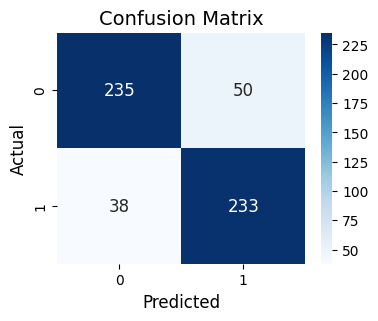

In [55]:
dt_cm = confusion_matrix(Y_test_smote, dt_pred)
plt.figure(figsize=(4,3))
sns_plot = sns.heatmap(dt_cm, annot=True, fmt='g', annot_kws={"fontsize":12}, cmap='Blues')
plt.ylabel("Actual", fontsize=12)
plt.xlabel("Predicted",fontsize=12)
plt.title("Confusion Matrix",fontsize=14)

In [56]:
f1_score(Y_test_smote, dt_pred).round(2)

np.float64(0.84)

### Hyperparameter Tuning

In [57]:
param_grid = {
    'max_depth': [i for i in range(2, 65)],
    'min_samples_leaf': [i for i in range(1, 33)],
    'criterion': ["gini", "entropy", "log_loss"]
} 

clf = DecisionTreeClassifier(random_state=1)
scorer = make_scorer(f1_score, average='weighted')
bayes_search = BayesSearchCV(estimator=clf, search_spaces=param_grid, cv=10, scoring=scorer, n_jobs=-1)
bayes_search.fit(X_train_smote, Y_train_smote)
best_params = bayes_search.best_params_
best_score = bayes_search.best_score_

print(f"Best parameters: {best_params}")
print(f"Best F1 weighted score: {best_score}")

c:\Users\User\miniconda3\envs\Global\Lib\site-packages\numpy\ma\core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
c:\Users\User\miniconda3\envs\Global\Lib\site-packages\numpy\ma\core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
c:\Users\User\miniconda3\envs\Global\Lib\site-packages\numpy\ma\core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
c:\Users\User\miniconda3\envs\Global\Lib\site-packages\numpy\ma\core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
c:\Users\User\miniconda3\envs\Global\Lib\site-packages\numpy\ma\core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
c:\Users\User\miniconda3\envs\Global\Lib\site-packages\numpy\ma\core.py:2846: RuntimeWarning: invalid value encount

Best parameters: OrderedDict({'criterion': 'log_loss', 'max_depth': 7, 'min_samples_leaf': 17})
Best F1 weighted score: 0.882195151736173


In [58]:
f1_score(Y_test_smote, bayes_search.predict(X_test_smote)).round(2)

np.float64(0.86)

Text(0.5, 1.0, 'Confusion Matrix')

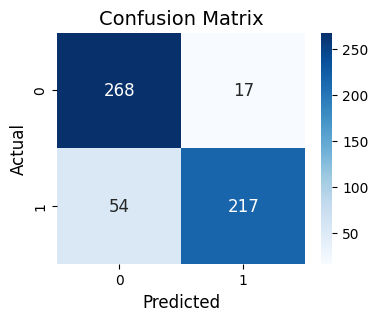

In [59]:
dt_cm = confusion_matrix(Y_test_smote, bayes_search.predict(X_test_smote))
plt.figure(figsize=(4,3))
sns_plot = sns.heatmap(dt_cm, annot=True, fmt='g', annot_kws={"fontsize":12}, cmap='Blues')
plt.ylabel("Actual", fontsize=12)
plt.xlabel("Predicted",fontsize=12)
plt.title("Confusion Matrix",fontsize=14)

In [60]:
print(classification_report(Y_test_smote, bayes_search.predict(X_test_smote)))

              precision    recall  f1-score   support

           0       0.83      0.94      0.88       285
           1       0.93      0.80      0.86       271

    accuracy                           0.87       556
   macro avg       0.88      0.87      0.87       556
weighted avg       0.88      0.87      0.87       556



## #6.2 Random Forest

In [61]:
rf = RandomForestClassifier(random_state=1)
rf = rf.fit(X_train_smote, Y_train_smote)
rf_pred = rf.predict(X_test_smote)

In [62]:
print(classification_report(Y_test_smote, rf_pred))

              precision    recall  f1-score   support

           0       0.90      0.94      0.92       285
           1       0.93      0.89      0.91       271

    accuracy                           0.91       556
   macro avg       0.91      0.91      0.91       556
weighted avg       0.91      0.91      0.91       556



Text(0.5, 1.0, 'Confusion Matrix')

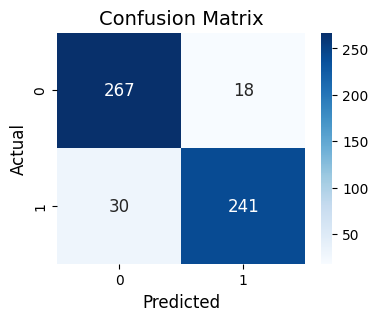

In [63]:
rf_cm = confusion_matrix(Y_test_smote, rf_pred)
plt.figure(figsize=(4,3))
sns_plot = sns.heatmap(rf_cm, annot=True, fmt='g', annot_kws={"fontsize":12}, cmap='Blues')
plt.ylabel("Actual", fontsize=12)
plt.xlabel("Predicted",fontsize=12)
plt.title("Confusion Matrix",fontsize=14)

### Hyperparameter Tuning

In [64]:
param_grid = {
    'max_depth': np.arange(2, 30),
    'min_samples_leaf': np.arange(1, 10),
    'criterion': ["gini", "entropy", "log_loss"]
} 

clf = RandomForestClassifier(random_state=1)
scorer = make_scorer(f1_score, average='weighted')
bayes_search = BayesSearchCV(estimator=clf, search_spaces=param_grid, cv=5, scoring=scorer, n_jobs=-1)
bayes_search.fit(X_train_smote, Y_train_smote)
best_params = bayes_search.best_params_
best_score = bayes_search.best_score_

print(f"Best parameters: {best_params}")
print(f"Best F1 weighted score: {best_score}")

Best parameters: OrderedDict({'criterion': 'log_loss', 'max_depth': 26, 'min_samples_leaf': 1})
Best F1 weighted score: 0.9139487476233328


In [67]:
f1_score(Y_test_smote, bayes_search.predict(X_test_smote)).round(2)

np.float64(0.91)

Text(0.5, 1.0, 'Confusion Matrix')

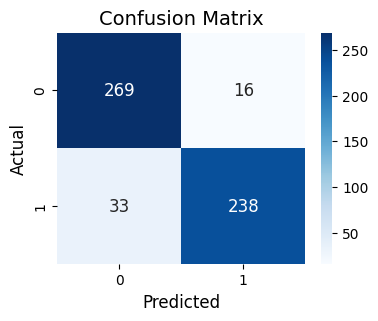

In [68]:
rf_cm = confusion_matrix(Y_test_smote, bayes_search.predict(X_test_smote))
plt.figure(figsize=(4,3))
sns_plot = sns.heatmap(rf_cm, annot=True, fmt='g', annot_kws={"fontsize":12}, cmap='Blues')
plt.ylabel("Actual", fontsize=12)
plt.xlabel("Predicted",fontsize=12)
plt.title("Confusion Matrix",fontsize=14)

In [69]:
print(classification_report(Y_test_smote, bayes_search.predict(X_test_smote)))

              precision    recall  f1-score   support

           0       0.89      0.94      0.92       285
           1       0.94      0.88      0.91       271

    accuracy                           0.91       556
   macro avg       0.91      0.91      0.91       556
weighted avg       0.91      0.91      0.91       556



## #6.3 KNN

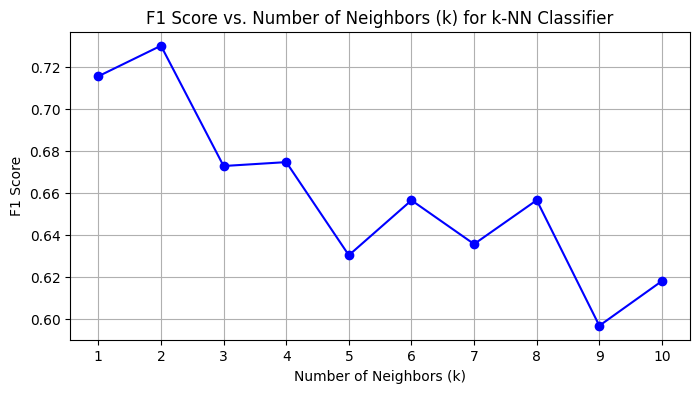

In [70]:
k_values = list(range(1, 11))
f1_scores = []
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_smote, Y_train_smote)
    y_pred = knn.predict(X_test_smote)
    f1 = f1_score(Y_test_smote, y_pred, average='weighted')
    f1_scores.append(f1)
    
plt.figure(figsize=(8, 4))
plt.plot(k_values, f1_scores, marker='o', linestyle='-', color='b')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('F1 Score')
plt.title('F1 Score vs. Number of Neighbors (k) for k-NN Classifier')
plt.xticks(k_values)
plt.grid(True)
plt.show()

In [71]:
knn = KNeighborsClassifier(n_neighbors=2)
knn.fit(X_train_smote, Y_train_smote)
knn_pred = knn.predict(X_test_smote)

In [72]:
print(classification_report(Y_test_smote, knn_pred))

              precision    recall  f1-score   support

           0       0.73      0.76      0.74       285
           1       0.73      0.70      0.72       271

    accuracy                           0.73       556
   macro avg       0.73      0.73      0.73       556
weighted avg       0.73      0.73      0.73       556



Text(0.5, 1.0, 'Confusion Matrix')

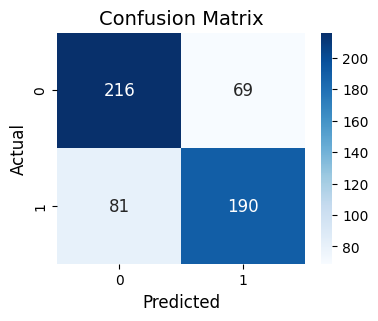

In [73]:
knn_cm = confusion_matrix(Y_test_smote, knn_pred)
plt.figure(figsize=(4,3))
sns_plot = sns.heatmap(knn_cm, annot=True, fmt='g', annot_kws={"fontsize":12}, cmap='Blues')
plt.ylabel("Actual", fontsize=12)
plt.xlabel("Predicted",fontsize=12)
plt.title("Confusion Matrix",fontsize=14)

## #6.4 SVM

In [74]:
svm = SVC(random_state=1)
svm = svm.fit(X_train_smote, Y_train_smote)
svm_pred = svm.predict(X_test_smote)

In [75]:
print(classification_report(Y_test_smote, svm_pred))

              precision    recall  f1-score   support

           0       0.69      0.58      0.63       285
           1       0.62      0.72      0.67       271

    accuracy                           0.65       556
   macro avg       0.65      0.65      0.65       556
weighted avg       0.65      0.65      0.65       556



Text(0.5, 1.0, 'Confusion Matrix')

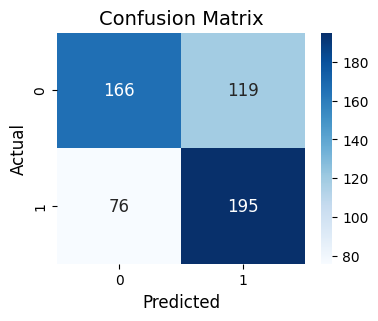

In [76]:
knn_svm = confusion_matrix(Y_test_smote, svm_pred)
plt.figure(figsize=(4,3))
sns_plot = sns.heatmap(knn_svm, annot=True, fmt='g', annot_kws={"fontsize":12}, cmap='Blues')
plt.ylabel("Actual", fontsize=12)
plt.xlabel("Predicted",fontsize=12)
plt.title("Confusion Matrix",fontsize=14)

### Hyperparameter Tuning

In [79]:
param_grid = {
    'C': [1e-10, 1e-5, 1e-1, 1, 10, 100, 1e5, 1e10],
    'kernel': ['rbf', 'sigmoid'],
    'gamma': ['scale', 'auto'],
}

svc = SVC(random_state=1)
bayes_search = BayesSearchCV(estimator=svc, search_spaces=param_grid, scoring='f1_weighted', cv=5, n_jobs=-1)
bayes_search.fit(X_train_smote, Y_train_smote)
best_params = bayes_search.best_params_
best_score = bayes_search.best_score_

print(f"Best Parameters: {best_params}")
print(f"Best F1 Score: {best_score:.2f}")

c:\Users\User\miniconda3\envs\Global\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.float64(100000.0), np.str_('scale'), np.str_('rbf')] before, using random point [10000000000.0, 'scale', 'sigmoid']
  warnings.warn(
c:\Users\User\miniconda3\envs\Global\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.float64(100000.0), np.str_('scale'), np.str_('rbf')] before, using random point [10000000000.0, 'scale', 'sigmoid']
  warnings.warn(
c:\Users\User\miniconda3\envs\Global\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.float64(100000.0), np.str_('scale'), np.str_('rbf')] before, using random point [1e-10, 'scale', 'rbf']
  warnings.warn(
c:\Users\User\miniconda3\envs\Global\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.float64(100000.0), np

Best Parameters: OrderedDict({'C': 100000.0, 'gamma': 'scale', 'kernel': 'rbf'})
Best F1 Score: 0.81


In [80]:
f1_score(Y_test_smote, bayes_search.predict(X_test_smote)).round(2)

np.float64(0.83)

Text(0.5, 1.0, 'Confusion Matrix')

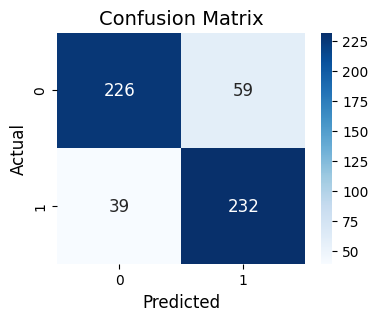

In [81]:
svm_cm = confusion_matrix(Y_test_smote, bayes_search.predict(X_test_smote))
plt.figure(figsize=(4,3))
sns_plot = sns.heatmap(svm_cm, annot=True, fmt='g', annot_kws={"fontsize":12}, cmap='Blues')
plt.ylabel("Actual", fontsize=12)
plt.xlabel("Predicted",fontsize=12)
plt.title("Confusion Matrix",fontsize=14)

In [82]:
print(classification_report(Y_test_smote, bayes_search.predict(X_test_smote)))

              precision    recall  f1-score   support

           0       0.85      0.79      0.82       285
           1       0.80      0.86      0.83       271

    accuracy                           0.82       556
   macro avg       0.83      0.82      0.82       556
weighted avg       0.83      0.82      0.82       556



# #7 Boosting Algorithms

## #7.1 XGBoost

In [83]:
xgb = XGBClassifier(random_state=1)
xgb = xgb.fit(X_train_smote, Y_train_smote)
xgb_pred = xgb.predict(X_test_smote)

In [84]:
print(classification_report(Y_test_smote, xgb_pred))

              precision    recall  f1-score   support

           0       0.91      0.92      0.92       285
           1       0.91      0.91      0.91       271

    accuracy                           0.91       556
   macro avg       0.91      0.91      0.91       556
weighted avg       0.91      0.91      0.91       556



Text(0.5, 1.0, 'Confusion Matrix')

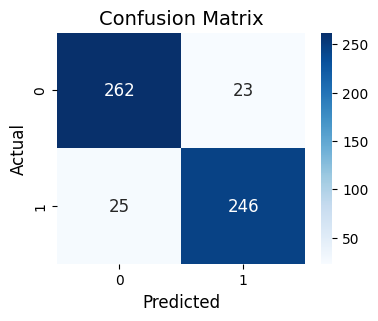

In [85]:
xgb_cm = confusion_matrix(Y_test_smote, xgb_pred)
plt.figure(figsize=(4,3))
sns_plot = sns.heatmap(xgb_cm, annot=True, fmt='g', annot_kws={"fontsize":12}, cmap='Blues')
plt.ylabel("Actual", fontsize=12)
plt.xlabel("Predicted",fontsize=12)
plt.title("Confusion Matrix",fontsize=14)

### Hyperparameter Tuning

In [87]:
f1_scorer = make_scorer(f1_score, average='weighted')
search_space = {
    'booster': Categorical(['gbtree', 'dart']),
    'lambda': Real(1e-8, 1.0, prior='log-uniform'),
    'alpha': Real(1e-8, 1.0, prior='log-uniform'),
    'subsample': Real(0.2, 1.0),
    'colsample_bytree': Real(0.2, 1.0),
    'scale_pos_weight': Real(1, 198),
    'max_depth': Integer(3, 9),
    'min_child_weight': Integer(2, 10),
    'eta': Real(1e-8, 1.0, prior='log-uniform'),
    'gamma': Real(1e-8, 1.0, prior='log-uniform'),
    'grow_policy': Categorical(['depthwise', 'lossguide']),
    'sample_type': Categorical(['uniform', 'weighted']),
    'normalize_type': Categorical(['tree', 'forest']),
    'rate_drop': Real(1e-8, 1.0, prior='log-uniform'),
    'skip_drop': Real(1e-8, 1.0, prior='log-uniform')
}

xgb_model = XGBClassifier(objective='multi:softmax', num_class=2, eval_metric='mlogloss')
opt = BayesSearchCV(estimator=xgb_model, search_spaces=search_space, n_iter=50, cv=5, scoring=f1_scorer, n_jobs=-1, random_state=1)
opt.fit(X_train_smote, Y_train_smote)

print(f"Best parameters: {opt.best_params_}")
print(f"Best F1 weighted score: {opt.best_score_}")

KeyboardInterrupt: 

In [ ]:
xgb_cm = confusion_matrix(Y_test_smote, opt.predict(X_test_smote))
plt.figure(figsize=(4,3))
sns_plot = sns.heatmap(xgb_cm, annot=True, fmt='g', annot_kws={"fontsize":12}, cmap='Blues')
plt.ylabel("Actual", fontsize=12)
plt.xlabel("Predicted",fontsize=12)
plt.title("Confusion Matrix",fontsize=14)

In [ ]:
print(classification_report(Y_test_smote, opt.predict(X_test_smote)))

## #7.2 LightGBM 

In [ ]:
lgbm = ltb.LGBMClassifier(random_state=1)
lgbm = lgbm.fit(X_train_smote, Y_train_smote)
lgbm_pred = lgbm.predict(X_test_smote)

In [ ]:
print(classification_report(Y_test_smote, lgbm_pred))

In [ ]:
lgbm_cm = confusion_matrix(Y_test_smote, lgbm_pred)
plt.figure(figsize=(4,3))
sns_plot = sns.heatmap(lgbm_cm, annot=True, fmt='g', annot_kws={"fontsize":12}, cmap='Blues')
plt.ylabel("Actual", fontsize=12)
plt.xlabel("Predicted",fontsize=12)
plt.title("Confusion Matrix",fontsize=14)

## #7.3 CatBoost

In [ ]:
cat = CatBoostClassifier(random_state = 42, verbose = 0)
cat = cat.fit(X_train_smote, Y_train_smote)
cat_pred = cat.predict(X_test_smote)

In [ ]:
print(classification_report(Y_test_smote, cat_pred))

In [ ]:
cat_cm = confusion_matrix(Y_test_smote, cat_pred)
plt.figure(figsize=(4,3))
sns_plot = sns.heatmap(cat_cm, annot=True, fmt='g', annot_kws={"fontsize":12}, cmap='Blues')
plt.ylabel("Actual", fontsize=12)
plt.xlabel("Predicted",fontsize=12)
plt.title("Confusion Matrix",fontsize=14)

# #8 DL Algorithms